# **Human Activity Recognition in Videos Using Conv-LSTM**

---


Import the required Libraries


In [ ]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-b0oigdwq/pafy_3d522289c2724d43b50c8b55f50afa62
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git /tmp/pip-install-b0oigdwq/pafy_3d522289c2724d43b50c8b55f50afa62
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py) ... done


In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

mount the Google Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download and Visualize the data with its Labels from drive

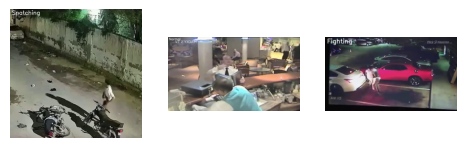

In [ ]:

# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in the dataset.
all_classes_names = os.listdir('/content/drive/MyDrive/NFS_Dataset')

# Set the sample size to 100 or the number of available classes, whichever is smaller.
sample_size = min(100, len(all_classes_names))

# Generate a list of `sample_size` random values.
random_range = random.sample(range(len(all_classes_names)), sample_size)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/NFS_Dataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/NFS_Dataset/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(10, 10, counter)  # Adjust the grid size to accommodate 100 samples.
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()

Preprocess the Dataset

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/drive/MyDrive/NFS_Dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Fighting", "Normal","Snatching"]

Created a function to Extract, Resize and Normalize Frames

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

Created a Function for Dataset Creation

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
import os

# Create a directory for the dataset if it doesn't exist
dataset_dir = '/content/drive/MyDrive/Dataset'
os.makedirs(dataset_dir, exist_ok=True)

Load the Features, Labels and video file from Google Drive

In [ ]:
# Load features, labels, and video file paths from Google Drive
features = np.load(os.path.join(dataset_dir, 'features.npy'))
labels = np.load(os.path.join(dataset_dir, 'labels.npy'))
video_files_paths = np.load(os.path.join(dataset_dir, 'video_files_paths.npy'))

print("Dataset loaded successfully from Google Drive.")


Dataset loaded successfully from Google Drive.


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Split the dataset into Training and Testing set

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

Construct the Conv-LSTM model

In [ ]:
from tensorflow.keras import regularizers

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    model = Sequential()

    model.add(ConvLSTM2D(filters=6, kernel_size=(2, 2), activation='tanh',
                        recurrent_dropout=0.1, return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01),
                        input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Additional ConvLSTM2D Layer for more complexity
    model.add(ConvLSTM2D(filters=8, kernel_size=(2, 2), activation='tanh',
                        recurrent_dropout=0.1, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Global Pooling to reduce Flatten's limitation
    model.add(GlobalAveragePooling3D())

    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))


    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 63, 63, 6)       │             888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 32, 32, 6)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 32, 32, 6)       │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 32, 32, 6)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 31, 31, 8)       │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 16, 16, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 16, 16, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 16, 16, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,539 (13.82 KB)

 Trainable params: 3,511 (13.71 KB)

 Non-trainable params: 28 (112.00 B)

Model Created Successfully!


Check Model Structure

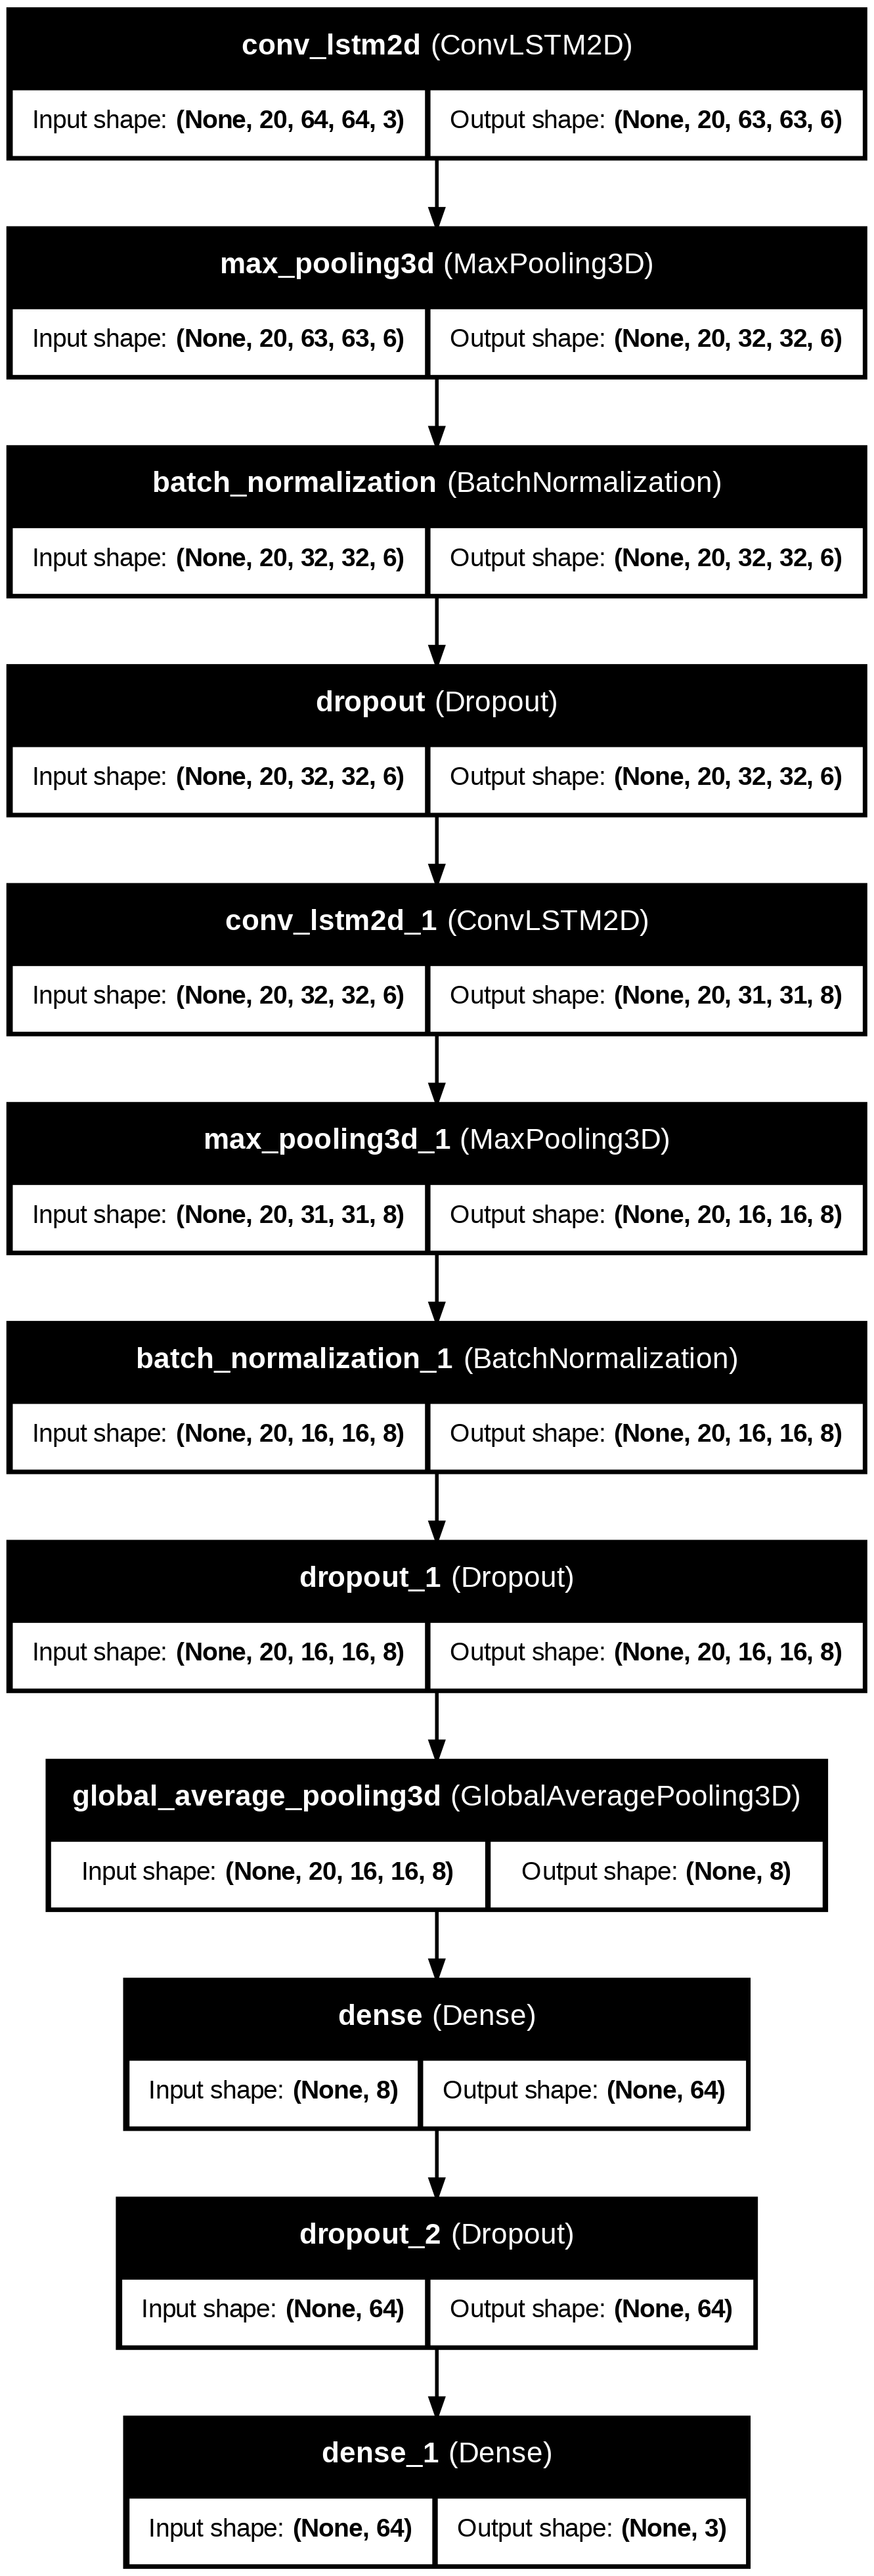

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Compile and train the Model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=1e-6)

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 90, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 32,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 621ms/step - accuracy: 0.2829 - loss: 1.1909 - val_accuracy: 0.3598 - val_loss: 1.1497
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.3159 - loss: 1.1669 - val_accuracy: 0.3738 - val_loss: 1.1471
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.3669 - loss: 1.1353 - val_accuracy: 0.3738 - val_loss: 1.1439
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.4037 - loss: 1.1266 - val_accuracy: 0.3738 - val_loss: 1.1400
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.4161 - loss: 1.1195 - val_accuracy: 0.3738 - val_loss: 1.1353
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.4557 - loss: 1.1054 - val_accuracy: 0.4065 - val_loss: 1.1298
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.4811 - loss: 1.0993 - val_accuracy: 0.4346 - val_loss: 1.1234
Epoch 8/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.4625 - loss: 1.0841 - val_ac

Evaluating the Trained Model

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.7822 - loss: 0.4174


Save the Model

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.keras'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

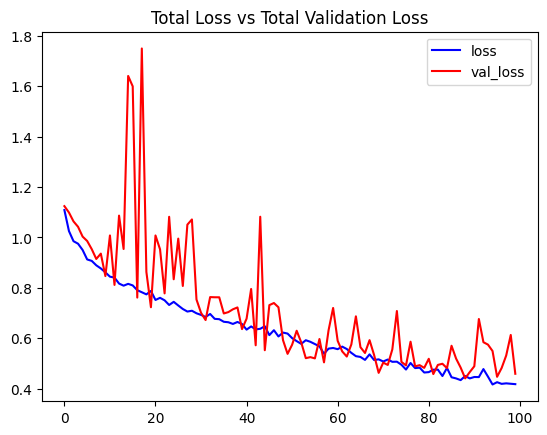

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

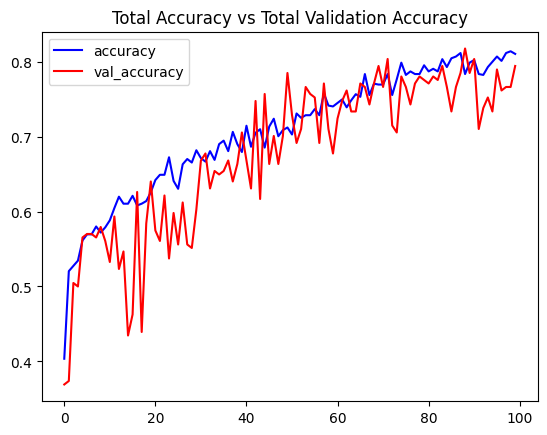

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')